In [1]:
%cd ..
import subprocess
import pandas as pd
from icecream import ic
from matplotlib import pyplot as plt

from scripts.utils_v2_for_jupyter import *


pd.set_option('display.max_columns', None)


/run/media/nazif/2F946E411BA61D49/thesis


In [2]:
def invoke_rnaduplex(long_sequence: str, short_sequence: str, energy_range: float = 5.0,
                     rnaduplex_location: str = "/usr/bin/RNAduplex") -> tuple:

    input_sequence = f"{long_sequence}\n{short_sequence}".encode()

    rnaduplex_subprocess = subprocess.Popen(
        [rnaduplex_location, "-e", f"{energy_range}", "-s"],
        stdout=subprocess.PIPE,
        stdin=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )

    output, error = rnaduplex_subprocess.communicate(input=input_sequence)
    rnaduplex_subprocess.wait()

    first_line = output.decode().split("\n")[0].split()

    dot_bracket_long, dot_bracket_short = first_line[0].split("&")
    start_long, end_long = map(int, first_line[1].split(","))
    start_short, end_short = map(int, first_line[3].split(","))
    energy = float(first_line[-1].strip("()"))

    mrna_slice = long_sequence[start_long-1:end_long]
    mirna_slice = short_sequence[start_short-1:end_short]


    return start_long, end_long, dot_bracket_long, start_short, end_short, dot_bracket_short, energy, mrna_slice, mirna_slice


def find_matches_with_rnaduplex(df):

    mrna_starts = []
    mrna_ends = []
    # mrna_dot_brackets = []
    mirna_starts = []
    mirna_ends = []
    mirna_dot_brackets = []
    energies = []

    # mrna_slices = []
    # mirna_slices = []

    for _, row in df.iterrows():
        start_long, end_long, dot_bracket_long, start_short, end_short, dot_bracket_short, energy, mrna_slice, mirna_slice = invoke_rnaduplex(
            row.mrna_sequence, row.mirna_sequence)

        mrna_starts.append(start_long)
        mrna_ends.append(end_long)
        # mrna_dot_brackets.append(dot_bracket_long)
        mirna_starts.append(start_short)
        mirna_ends.append(end_short)
        mirna_dot_brackets.append(dot_bracket_short)
        energies.append(energy)

        # mrna_slices.append(mrna_slice)
        # mirna_slices.append(mirna_slice)

    # getting columns from clash df
    ids = df["id"]
    
    true_seed_types = df["true_seed_type"]
    true_no_bps = df["num_basepairs"]
    true_seed_bps = df["seed_basepairs"]
    true_energies = df["folding_energy"]
    mirna_sequences = df["mirna_sequence"]
    gene_names = df["gene_name"]
    mirna_names = df["mirna_name"]

    df = pd.DataFrame({"id": ids,
                       "gene_name": gene_names,
                       "mirna_name": mirna_names,
                       "mirna_sequence": mirna_sequences,

                       "mrna_start": mrna_starts,
                       "mrna_end": mrna_ends,

                       "pred_energy": energies,
                       "true_energy": true_energies,
                       
                       "mirna_start": mirna_starts,
                       "mirna_end": mirna_ends,
                       "mirna_dot_bracket_5to3": mirna_dot_brackets,
                       
                       "true_seed_type": true_seed_types,
                       "true_num_basepairs": true_no_bps,
                       "true_seed_basepairs": true_seed_bps

                       })

    return df




def generate_alignment_strings(df):
    
    
    full_strings = []
    
    for _, row in df.iterrows():
        
        start_string = (row.mirna_start - 1) * "0"
        mid_string = row["mirna_dot_bracket_5to3"].replace(".", "0").replace(")", "1")
        end_string = (len(row.mirna_sequence) - row.mirna_end) * "0"
        
        full_string = start_string + mid_string + end_string
        
        full_strings.append(full_string)
        
    df["alignment_string"] = full_strings
    df.drop("mirna_dot_bracket_5to3", axis=1, inplace=True)
    # df.drop("mirna_start", axis=1, inplace=True)
    # df.drop("mirna_end", axis=1, inplace=True)
    
    
    return df


def count_basepairs(df):
    
    def count_ones(str, seed=False):
        return str[1:7].count("1") if seed else str.count("1")

    df["pred_num_basepairs"] = df["alignment_string"].apply(count_ones)

    df["pred_seed_basepairs"] = df["alignment_string"].apply(count_ones, seed=True)

    return df

#####################################

clash_df = clash()
# df = find_matches_with_rnaduplex(clash_df)
# df.to_csv("results/rnaduplex_predictions.csv", index=False)
df = pd.read_csv("results/rnaduplex_predictions.csv")
df = generate_alignment_strings(df)
df = count_basepairs(df)

df.head()

,id,gene_name,mirna_name,mirna_sequence,mrna_start,mrna_end,pred_energy,true_energy,mirna_start,mirna_end,true_seed_type,true_num_basepairs,true_seed_basepairs,alignment_string,pred_num_basepairs,pred_seed_basepairs
0,0727A-1038930_1,CCNG1,let-7a,TGAGGTAGTAGGTTGTATAGTT,23,46,-27.7,-25.1,1,21,noncanonical_seed,20,6,1111111111111111111100,20,6
1,L1HS-1112536_1,DICER1,let-7a,TGAGGTAGTAGGTTGTATAGTT,12,31,-26.2,-24.4,1,19,9-mer,17,6,1111111110111111110000,17,6
2,L2HS-818542_2,SESN1,let-7a,TGAGGTAGTAGGTTGTATAGTT,4,25,-23.6,-22.2,1,22,noncanonical_seed,19,6,0111111011111111111110,19,6
3,L2HS-1161339_2,NIPBL,let-7a,TGAGGTAGTAGGTTGTATAGTT,4,25,-23.8,-22.1,1,22,noncanonical_seed,18,6,1111111000111111111111,19,6
4,L2-407944_2,INTS12,let-7a,TGAGGTAGTAGGTTGTATAGTT,3,25,-24.0,-21.9,1,22,noncanonical_seed,18,6,1111111111111100011110,18,6


# exploratory stuff

<Axes: >

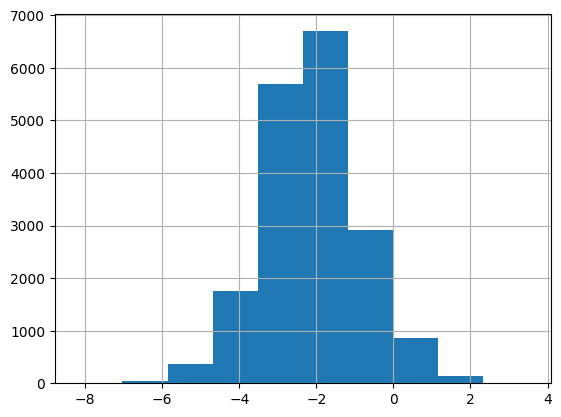

In [ ]:
df["energy_difference"] = df["pred_energy"] - df["true_energy"]
df.energy_difference.hist()

# energy diff ile alakalı droplanacak bir şey bulamadım

<Axes: >

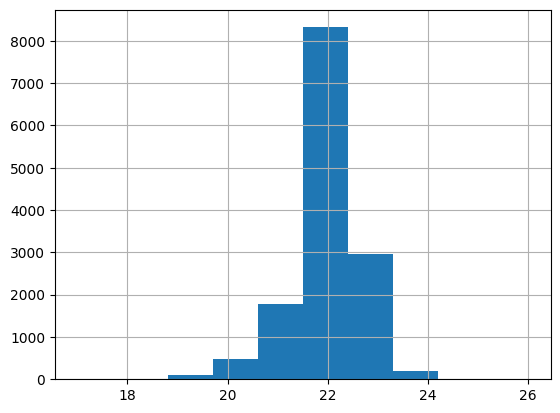

In [ ]:
df["mirna_length"] = df.mirna_sequence.apply(len)

df.mirna_length.hist()

In [ ]:
df["seed_bp_difference"] = df["pred_seed_basepairs"] - df["true_seed_basepairs"]
df.seed_bp_difference.value_counts()


# difference 1'den fazla olanları droplasam iyi olur

/tmp/ipykernel_24530/1989198344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["seed_bp_difference"] = df["pred_seed_basepairs"] - df["true_seed_basepairs"]


seed_bp_difference
 0    14956
 1     1267
 2      653
-1      539
-2      300
-3      125
-4       54
-5       24
-6       10
Name: count, dtype: int64

In [ ]:
df["bp_difference"] = df["pred_num_basepairs"] - df["true_num_basepairs"]
df.bp_difference.hist()


In [ ]:
print(df[df["true_seed_basepairs"] <= 4].true_seed_type.value_counts())


true_seed_type
none               870
noseed_9nt_stem    655
6-mer                8
7-mer                6
8-mer                5
Name: count, dtype: int64
before: 13915
after: 13896


/tmp/ipykernel_28363/3031930601.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.drop(df[mask2].index, inplace=True)
/tmp/ipykernel_28363/3031930601.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.drop(df[mask3].index, inplace=True)


<Axes: >

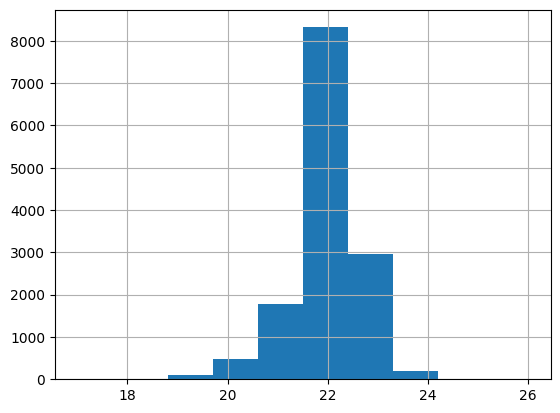

In [ ]:
df["mirna_length"] = df.mirna_sequence.apply(len)

df.mirna_length.hist()